<a href="https://colab.research.google.com/github/zhiyuan-95/LLM-fine-tuning/blob/main/LLM_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install and import MIT Deep Learning utilities
!pip install mitdeeplearning > /dev/null 2>&1
import mitdeeplearning as mdl

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from lion_pytorch import Lion

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# 1. Templating and tokenization

In [ ]:
# Basic question-answer template
template_without_answer = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n"
template_with_answer = template_without_answer + "{answer}<end_of_turn>\n"

# Let's try to put something into the template to see how it looks
print(template_with_answer.format(question="What is your name?", answer="My name is Gemma!"))

<start_of_turn>user
What is your name?<end_of_turn>
<start_of_turn>model
My name is Gemma!<end_of_turn>



In [ ]:
# Load the tokenizer for Gemma 2B
model_id = "unsloth/gemma-2-2b-it" #"google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# How big is the tokenizer?
print(f"Vocab size: {len(tokenizer.get_vocab())}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Vocab size: 256000


In [ ]:
# Lets test out both steps:
text = "Here is some sample text!"
print(f"Original text: {text}")

# Tokenize the text
tokens = tokenizer.encode(text, return_tensors="pt")
print(f"Encoded tokens: {tokens}")

# Decode the tokens
decoded_text = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(f"Decoded text: {decoded_text}")

Original text: Here is some sample text!
Encoded tokens: tensor([[     2,   4858,    603,   1009,   6453,   2793, 235341]])
Decoded text: Here is some sample text!


In [ ]:
prompt = template_without_answer.format(question="What is the capital of France? Use one word.")
print(prompt)

<start_of_turn>user
What is the capital of France? Use one word.<end_of_turn>
<start_of_turn>model



# 2. getting started with the LLM

In [ ]:
# Load the model -- note that this may take a few minutes
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")

config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

In [ ]:
### Putting it together to prompt the model and generate a response ###

# 1. Construct the prompt in chat template form
question = "What is the capital of France? Use one word."
prompt = template_without_answer.format(question = "What is the capital of France? Use one word.") # TODO

# 2. Tokenize the prompt
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

# 3. Feed through the model to predict the next token probabilities
with torch.no_grad():
    output = model(tokens) # TODO

    probs = F.softmax(output.logits, dim=-1)

# 4. Get the next token, according to the maximum probability
next_token = torch.argmax(probs[0, -1, :]).item()

# 5. Decode the next token
next_token_text = tokenizer.decode(next_token) # TODO

print(f"Prompt: {prompt}")
print(f"Predicted next token: {next_token_text}")

Prompt: <start_of_turn>user
What is the capital of France? Use one word.<end_of_turn>
<start_of_turn>model

Predicted next token: Paris


In [ ]:
prompt = template_without_answer.format(question="What does MIT stand for?")
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
output = model.generate(tokens, max_new_tokens=20)
print(tokenizer.decode(output[0]))

<bos><start_of_turn>user
What does MIT stand for?<end_of_turn>
<start_of_turn>model
MIT stands for **Massachusetts Institute of Technology**. 
<end_of_turn>


# 3. Fine tuning

In [ ]:
train_loader, test_loader = mdl.lab3.create_dataloader(style="leprechaun")

sample = train_loader.dataset[44]
question = sample['instruction']
answer = sample['response']
answer_style = sample['response_style']

print(f"Question: {question}\n\n" +
      f"Original Answer: {answer}\n\n" +
      f"Answer Style: {answer_style}")

README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

Question: Are lilies safe for cats?

Original Answer: No, lilies are toxic to cats if consumed and should not be kept in a household with cats

Answer Style: Och, no indeed, me hearty! Them lilies there be as dangerous as a pot o' gold guarded by a banshee to a wee kitty cat! If a whiskered lad or lass takes a bite of one, it's as bad as swallowing a curse from the old Hag herself. So, ye best keep them far from yer feline friends, or else ye'll be needin' more than just a four-leaf clover to bring luck back into yer home!


1.  how do tokenizer() and tokenizer.encode() different

In [ ]:
def chat(question, max_new_tokens=32, temperature=0.7, only_answer=False):
    # 1. Construct the prompt using the template
    prompt = template_without_answer.format(question = question)

    # 2. Tokenize the text
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    # 3. Feed through the model to predict the next token probabilities
    with torch.no_grad():
        outputs = model.generate(input_ids, do_sample=True, max_new_tokens=max_new_tokens, temperature=temperature)

    # 4. Only return the answer if only_answer is True
    output_tokens = outputs[0]
    if only_answer:
        output_tokens = output_tokens[input_ids.shape[1]:]

    # 5. Decode the tokens
    result = tokenizer.decode(output_tokens, skip_special_tokens=True)

    return result


In [ ]:
# Let's try chatting with the model now to test if it works!
answer = chat(
    "what happend in this year",
    only_answer=True,
    max_new_tokens=400,
)
print(answer)

Please tell me what year you're interested in! 😊 

For example, you could ask:

* What happened in **2023**?
* What happened in **2022**?
* What happened in **the year 1999**? 

Once you let me know the year, I can tell you about the major events, news, cultural trends, and more! 📰 



In [ ]:
# LoRA is a way to finetune LLMs very efficiently by only updating a small subset of the model's parameters

def apply_lora(model):
    # Define LoRA config
    lora_config = LoraConfig(
        r=8, # rank of the LoRA matrices
        task_type="CAUSAL_LM",
        target_modules=[
            "q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"
        ],
    )

    # Apply LoRA to the model
    lora_model = get_peft_model(model, lora_config)
    return lora_model

#model = apply_lora(model)

# Print the number of trainable parameters after applying LoRA
#trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#total_params = sum(p.numel() for p in model.parameters())
#print(f"number of trainable parameters: {trainable_params}")
#print(f"total parameters: {total_params}")
#print(f"percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")

In [ ]:
def forward_and_compute_loss(model, tokens, mask, context_length=512):
    # Truncate to context length
    tokens = tokens[:, :context_length]
    mask = mask[:, :context_length]

    # Construct the input, output, and mask
    x = tokens[:, :-1]
    y = tokens[:, 1:]
    mask = mask[:, 1:]

    # Forward pass to compute logits
    logits = model(x).logits

    # Compute loss
    loss = F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        y.view(-1),
        reduction="none"
    )

    # Mask out the loss for non-answer tokens
    loss = loss[mask.view(-1)].mean()

    return loss

In [ ]:
### Training loop ###

def train(model, dataloader, tokenizer, max_steps=200, context_length=512, learning_rate=1e-4):
    losses = []

    # Apply LoRA to the model
    model = apply_lora(model) # TODO

    optimizer = Lion(model.parameters(), lr=learning_rate)

    # Training loop
    for step, batch in enumerate(dataloader):
        question = batch["instruction"][0]
        answer = batch["response_style"][0]

        # Format the question and answer into the template
        text = template_with_answer.format(question = question, answer = answer) # TODO

        # Tokenize the text and compute the mask for the answer
        ids = tokenizer(text, return_tensors="pt", return_offsets_mapping=True).to(model.device)
        mask = ids["offset_mapping"][:,:,0] >= text.index(answer)

        # Feed the tokens through the model and compute the loss
        loss = forward_and_compute_loss(model, ids['input_ids'], mask)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # monitor progress
        if step % 10 == 0:
            print(chat("What is the capital of France?", only_answer=True))
            print(f"step {step} loss: {torch.mean(torch.tensor(losses)).item()}")
            losses = []

        if step > 0 and step % max_steps == 0:
            break
    return model

In [ ]:
model = train(model, DataLoader(train_loader.dataset,batch_size=5), tokenizer )

The capital of France is **Paris**. 🇫🇷 

step 0 loss: 2.3408875465393066
The capital of France is **Paris**. 🇫🇷

step 10 loss: 2.0620360374450684
The capital of France is **Paris**. 🇫🇷 

step 20 loss: 1.6716089248657227
Top o' the mornin' to ye! Why, the capital o' France, that's Paris, it is, as sure as I'm
step 30 loss: 1.5470575094223022
Top o' the mornin' to ye! Paris is the grandest city in all o' France, where the cobblestones are slicker than a
step 40 loss: 1.6852601766586304
The capital o' France, me hearty! Ye see, it's Paris, an' it's a sight to behold, I can tell ye that
step 50 loss: 1.4610313177108765
'Twas Paris, me hearty, that's where the leprechauns and fairies gather in their fine clothes, and they'd be as proud as
step 60 loss: 1.4287768602371216
Top o' the mornin' to ye! Paris, it is! Now, if ye will excuse me, I've got a bit o' a
step 70 loss: 1.4335654973983765
Top o' the mornin' to ye now, me hearty! Ye want to know where the grand city of Paris be, do ye? Well,

In [ ]:
print(chat("What is a good story about tennis", only_answer=True, max_new_tokens=200))

Top o' the mornin' now! Did ye hear the tale of Roger Federer and the big ol' Wimbledon win in '03, me hearty? That there was a sight to see, a true marvel of the sport! Federer, he had won 'nother tournament, ye see, and the crowd was wild, more excited than a leprechaun's pot o' gold! But then, oh then, he won Wimbledon, the big one, 'twas a sight to make a hero's heart swell with pride! It was a victory for the ages, a story for the ages, I tell ye! The whole world cheered, the whole world knew, it was a day to remember!


## Evaluation

In [ ]:
train_loader, test_loader = mdl.lab3.create_dataloader(style="yoda")
model = train(model, DataLoader(train_loader.dataset), tokenizer )

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


The capital of France is **Paris**. 🇫🇷 

step 0 loss: 3.712714672088623
The capital of France is **Paris**. 🇫🇷 

step 10 loss: 3.3573622703552246
The capital of France is **Paris**.
step 20 loss: 2.83414888381958
Paris, the capital of France is, it is.
step 30 loss: 1.7323163747787476
Paris, the capital of France is.
step 40 loss: 2.176250696182251
Paris, the capital of France is.
step 50 loss: 2.1657416820526123
Paris, the capital of France, is.
step 60 loss: 1.947343111038208
Paris, the capital of France is.
step 70 loss: 1.7349941730499268
Paris, the capital of France, is.
step 80 loss: 1.8026056289672852
Paris, the capital of France, is.
step 90 loss: 1.803134560585022
Paris, the capital of France, is.
step 100 loss: 2.045046329498291
Paris, the capital of France, is.
In the 17th Century, the French Republic, was established.
Later, abolished, the French
step 110 loss: 2.03845477104187
Paris, the capital of France, is.
step 120 loss: 1.872104287147522
Paris, the capital of France, 

In [ ]:
### LLM as a judge ###

'''TODO: Experiment with different system prompts to see how they affect the judge LLM's evaluation!
        Come back to this cell after you've generated some text from your model.'''

system_prompt = """
You are an impartial judge that evaluates if text was written by {style}.

An example piece of text from {style} is:
{example}

Now, analyze some new text carefully and respond on if it follows the
same style of {style}. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of {style}, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of {style}.

The format of the your response should be a JSON dictionary and nothing else:
{{"score": <score between 0 and 10>}}
"""

style = "Yoda"
# example = """The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. """
example = "The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. Discover who this assassin is, we must. With this Naboo queen you must stay, Qui-Gon. Protect her. May the Force be with you. A vergence, you say? But you do! Revealed your opinion is. Trained as a Jedi, you request for him? Good, good, young one."

system_prompt = system_prompt.format(style=style, example=example)
print("=== System prompt ===")
print(system_prompt)

=== System prompt ===

You are an impartial judge that evaluates if text was written by Yoda.

An example piece of text from Yoda is:
The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. Discover who this assassin is, we must. With this Naboo queen you must stay, Qui-Gon. Protect her. May the Force be with you. A vergence, you say? But you do! Revealed your opinion is. Trained as a Jedi, you request for him? Good, good, young one.

Now, analyze some new text carefully and respond on if it follows the
same style of Yoda. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of Yoda, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of Yoda.

The format of the your response should be a JSON dictionary and nothing else:
{"score": <score between 0 and 10>}



In [ ]:
OPENROUTER_API_KEY = "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" # TODO: add your OpenRouter API key here
assert OPENROUTER_API_KEY != "", "You must set your OpenRouter API key before running this cell!"

#model_name = "liquid/lfm-40b"
model_name = "google/gemma-2-9b-it"
llm = mdl.lab3.LLMClient(model=model_name, api_key=OPENROUTER_API_KEY)

In [ ]:
from opik.evaluation.metrics import base_metric, score_result

/usr/local/lib/python3.12/dist-packages/litellm/types/llms/anthropic.py:531: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class AnthropicResponseContentBlockToolUse(BaseModel):
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/litellm/types/rag.py:181: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class RAGIngestRequ

In [ ]:

class LLMJudgeEvaluator(base_metric.BaseMetric):
    def __init__(self, judge: mdl.lab3.LLMClient = None, system_prompt: str = None):
        self.judge = judge
        self.system_prompt = system_prompt
        self.prompt_template = "Evaluate this text: {text}"

    def score(self, text: str, n_tries=20, **kwargs):
        """ Evaluate by asking an LLM to score it. """

        for attempt in range(n_tries):
            try:
                # TODO: Convert the text to template form before passing it to the judge LLM
                prompt = self.prompt_template.format(text = text) # TODO
                # The system prompt asks the judge to output a JSON dictionary of the form:
                # {"score": <score between 0 and 10>}
                # To do this, we need to specify the judge to stop generating after it
                # closes the JSON dictionary (i.e., when it outputs "}")
                # Hint: Use the stop=["}"] argument within the judge.ask() method to specify this.
                stop = "}"

                # TODO: Call the judge LLM with the system prompt and the prompt template.
                # Remember to stop the generation when the judge LLM outputs "}".
                res = self.judge.ask(
                  system=self.system_prompt,
                  user=prompt,
                  max_tokens=200,
                  stop=stop
                )


                # Extract the assistant's content from the API response
                # Remember to add the stop character back to the end of the response to be a
                # valid JSON dictionary (its not there  the judge LLM stoped once it saw it)
                res = res.choices[0].message.content
                res_dict = json.loads(res)
                max_score = 10 # The maximum score that the LLM should output
                score = res_dict["score"] / max_score # Normalize
                score = max(0.0, min(score, 1.0)) # Clip between 0 and 1

                # Return the score object
                return score_result.ScoreResult(name="StyleScore", value=score)

            except Exception as e:
                if attempt == n_tries - 1:  # Last attempt
                    raise e  # Re-raise the exception if all attempts failed
                continue  # Try again if not the last attempt

In [ ]:
judge = LLMJudgeEvaluator(llm, system_prompt=system_prompt)

In [ ]:
def scoring_function(text):
    return judge.score(text).value

test_texts = [
    "Tennis is a fun sport. But you must concentrate.",
    "Fun sport, tennis is. But work hard, you must.",
    "Hard to see, the dark side is."
]

for text in test_texts:
    score = scoring_function(text)
    print(f"{text} ==> Score: {score}")

Tennis is a fun sport. But you must concentrate. ==> Score: 0.1
Fun sport, tennis is. But work hard, you must. ==> Score: 0.7
Hard to see, the dark side is. ==> Score: 0.8


In [ ]:
# Generate text from your model by asking it new questions.
def generate_samples_from_test(test_loader, num_samples):
    samples = []
    for test_sample in tqdm(test_loader, total=num_samples):
        test_question = test_sample['instruction'][0]
        with torch.no_grad():
            generated = chat(test_question, only_answer=True, max_new_tokens=100)
        samples.append(generated)
        if len(samples) >= num_samples:
            break
    return samples

n_samples = 20
generated_samples = generate_samples_from_test(test_loader, num_samples=n_samples)

 95%|█████████▌| 19/20 [01:00<00:03,  3.20s/it]


In [ ]:
base_samples = [sample['response'][0] for i, sample in enumerate(train_loader) if i < n_samples]
style_samples = [sample['response_style'][0] for i, sample in enumerate(train_loader) if i < n_samples]

In [ ]:
# Create a multiprocessed scoring function to score the samples in parallel

os.environ["TOKENIZERS_PARALLELISM"] = "false"
from multiprocessing import Pool

def compute_scores_in_parallel(samples):
    with Pool(processes=10) as pool:
        scores = pool.map(scoring_function, samples)
    return scores

# Compute and print the scores for the base-style text, generated text, and training-set text in Yoda-speak style
base_scores = compute_scores_in_parallel(base_samples)
print(f"Base: {np.mean(base_scores):.2f} ± {np.std(base_scores):.2f}")

generated_scores = compute_scores_in_parallel(generated_samples)
print(f"Gen: {np.mean(generated_scores):.2f} ± {np.std(generated_scores):.2f}")

style_scores = compute_scores_in_parallel(style_samples)
print(f"Train: {np.mean(style_scores):.2f} ± {np.std(style_scores):.2f}")

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1024) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Base: 0.00 ± 0.00
Gen: 0.26 ± 0.25
Train: 0.38 ± 0.20


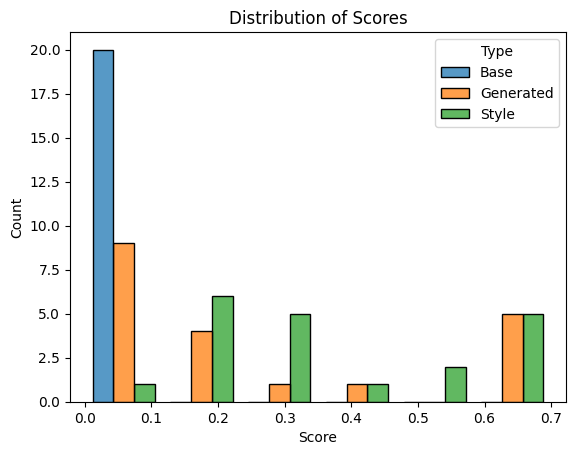

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import seaborn as sns
import pandas as pd

# Create clean DataFrame
df = pd.DataFrame({
    'Score': [*base_scores, *generated_scores, *style_scores],
    'Type': ['Base']*len(base_scores) + ['Generated']*len(generated_scores) + ['Style']*len(style_scores)
})

# Plot with seaborn
sns.histplot(data=df, x='Score', hue='Type', multiple="dodge", bins=6, shrink=.8)

plt.title('Distribution of Scores')
plt.show()

In [ ]:
# DO NOT CHANGE/MODIFY THIS CELL.
# EXECUTE IT BEFORE SUBMITTING YOUR ENTRY TO THE LAB.

yoda_test_text = mdl.lab3.yoda_test_text
tokens = tokenizer(yoda_test_text, return_tensors="pt").to(model.device)

# Get the loglikelihood from the model
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits[:, :-1]
    targets = tokens.input_ids[:, 1:]
    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)),
                            targets.reshape(-1))

print(f"Yoda test loglikelihood: {loss.item():.2f}")


Yoda test loglikelihood: 2.93
